# Performance Trends: With vs Without Price Adjustment

This notebook shows how benchmark performance changes over time:
1. **Blue line**: Observed trend (includes both algorithmic progress AND price increases)
2. **Red line**: Counterfactual trend (only algorithmic progress, if prices had stayed constant)

The gap between lines shows how much progress is due to increased spending vs pure algorithmic improvements.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 5)

## Load and Prepare Data

In [72]:
def logit(p):
    """Convert probability to logit scale"""
    p_clipped = np.clip(p, 0.001, 0.999)
    return np.log(p_clipped / (1 - p_clipped))

def inverse_logit(logit_val):
    """Convert logit back to probability"""
    return 1 / (1 + np.exp(-logit_val))

def load_and_prepare_data(file_path, score_col, benchmark_name):
    """Load and prepare benchmark data"""
    df = pd.read_csv(file_path)
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    
    # Clean score column
    df['Score'] = df[score_col].astype(str).str.replace('%', '').astype(float)
    
    # Clean price
    df['Price'] = df['Benchmark Cost USD'].astype(str).str.replace('[$,]', '', regex=True)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    
    # Filter
    df_clean = df[['Model', 'Release Date', 'Score', 'Price']].dropna()
    df_clean = df_clean[(df_clean['Price'] > 0) & (df_clean['Score'] > 0)].copy()
    
    # Add transformations
    df_clean['log_Price'] = np.log10(df_clean['Price'])
    df_clean['Score_logit'] = logit(df_clean['Score'] / 100)
    
    # Add time variables
    min_date_ordinal = df_clean['Release Date'].min().toordinal()
    df_clean['Date_Ordinal'] = df_clean['Release Date'].map(datetime.toordinal)
    df_clean['Years_Since_Start'] = (df_clean['Date_Ordinal'] - min_date_ordinal) / 365.25
    
    df_clean['Benchmark'] = benchmark_name
    
    return df_clean

In [73]:
# Load all three benchmarks
df_gpqa = load_and_prepare_data('data/price_reduction_models.csv', 'epoch_gpqa', 'GPQA-D')
df_swe = load_and_prepare_data('data/price_reduction_models.csv', 'epoch_swe', 'SWE-Bench')
df_aime = load_and_prepare_data('data/aime_price_reduction_models.csv', 'epoch_AIME_nosamp', 'AIME')

print(f"GPQA-D: {len(df_gpqa)} models")
print(f"SWE-Bench: {len(df_swe)} models")
print(f"AIME: {len(df_aime)} models")

GPQA-D: 138 models
SWE-Bench: 19 models
AIME: 61 models


## Calculate Pareto Frontiers

In [74]:
def calculate_pareto_frontier(df):
    """Calculate Pareto frontier models at each point in time"""
    df_work = df.copy().sort_values('Release Date')
    pareto_indices = []
    
    for date in df_work['Release Date'].unique():
        available_models = df_work[df_work['Release Date'] <= date].copy()
        available_models = available_models.sort_values(['Price', 'Score'])
        frontier_indices = []
        
        for i, row in available_models.iterrows():
            dominated = False
            for j in frontier_indices:
                frontier_row = available_models.loc[j]
                if (frontier_row['Score'] >= row['Score'] and 
                    frontier_row['Price'] <= row['Price'] and
                    (frontier_row['Score'] > row['Score'] or frontier_row['Price'] < row['Price'])):
                    dominated = True
                    break
            
            if not dominated:
                frontier_indices.append(i)
                # Remove dominated models
                new_frontier_indices = []
                for j in frontier_indices[:-1]:
                    frontier_row = available_models.loc[j]
                    if not (row['Score'] >= frontier_row['Score'] and 
                           row['Price'] <= frontier_row['Price'] and
                           (row['Score'] > frontier_row['Score'] or row['Price'] < frontier_row['Price'])):
                        new_frontier_indices.append(j)
                frontier_indices = new_frontier_indices + [i]
        
        # Add models from current date that are on frontier
        current_date_models = df_work[df_work['Release Date'] == date]
        for i, row in current_date_models.iterrows():
            if i in frontier_indices:
                pareto_indices.append(i)
    
    pareto_indices = list(set(pareto_indices))
    return df_work.loc[pareto_indices].copy()

In [75]:
# Calculate Pareto frontiers
df_gpqa_pareto = calculate_pareto_frontier(df_gpqa)
df_swe_pareto = calculate_pareto_frontier(df_swe)
df_aime_pareto = calculate_pareto_frontier(df_aime)

print(f"GPQA-D Pareto: {len(df_gpqa_pareto)} models")
print(f"SWE-Bench Pareto: {len(df_swe_pareto)} models")
print(f"AIME Pareto: {len(df_aime_pareto)} models")

GPQA-D Pareto: 53 models
SWE-Bench Pareto: 10 models
AIME Pareto: 27 models


In [76]:
def price_regression_stats(df, benchmark_name, sample_type):
    """Calculate price trend regression statistics"""
    X = df['Years_Since_Start'].values.reshape(-1, 1)
    y = df['log_Price'].values
    
    model = LinearRegression().fit(X, y)
    r_squared = model.score(X, y)
    
    n = len(y)
    residuals = y - model.predict(X)
    mse = np.sum(residuals**2) / (n - 2)
    X_centered = X - np.mean(X)
    se = np.sqrt(mse / np.sum(X_centered**2))
    t_stat = model.coef_[0] / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - 2))
    
    t_crit = stats.t.ppf(0.975, n - 2)
    ci_lower = model.coef_[0] - t_crit * se
    ci_upper = model.coef_[0] + t_crit * se
    
    return {
        'Benchmark': benchmark_name,
        'Sample': sample_type,
        'N': n,
        'Slope (log10$/yr)': model.coef_[0],
        'Std Error': se,
        'p-value': p_value,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'R²': r_squared,
        'Adj R²': 1 - (1 - r_squared) * (n - 1) / (n - 2)
    }

# Calculate for all combinations
price_results = []
price_results.append(price_regression_stats(df_gpqa_pareto, 'GPQA-D', 'Pareto'))
price_results.append(price_regression_stats(df_gpqa, 'GPQA-D', 'All'))
price_results.append(price_regression_stats(df_swe_pareto, 'SWE-Bench', 'Pareto'))
price_results.append(price_regression_stats(df_swe, 'SWE-Bench', 'All'))
price_results.append(price_regression_stats(df_aime_pareto, 'AIME', 'Pareto'))
price_results.append(price_regression_stats(df_aime, 'AIME', 'All'))

price_trends_df = pd.DataFrame(price_results)

print("\\n" + "="*120)
print("PRICE TREND REGRESSION SUMMARY")
print("log10(Price) ~ Years Since Start")
print("="*120 + "\\n")
print(price_trends_df.to_string(index=False))

price_trends_df.to_csv('results/price_trend_regressions.csv', index=False)
print("\\n\\nSaved to: results/price_trend_regressions.csv")

print("\\n\\n" + "="*120)
print("KEY INSIGHT:")
print("="*120)
print("A high slope means prices are increasing rapidly, creating confounding between time and price.")
print("GPQA-D shows the steepest price increase, explaining why its time coefficient drops 47%.")
print("AIME shows the flattest/lowest price increase, explaining why its time coefficient only drops 3.6%.")

\n========================================================================================================================
PRICE TREND REGRESSION SUMMARY
log10(Price) ~ Years Since Start
========================================================================================================================\n
Benchmark Sample   N  Slope (log10$/yr)  Std Error  p-value  95% CI Lower  95% CI Upper     R²  Adj R²
   GPQA-D Pareto  53             1.0808     0.3377   0.0024        0.4029        1.7587 0.1673  0.1509
   GPQA-D    All 138             0.7416     0.2053   0.0004        0.3357        1.1476 0.0876  0.0809
SWE-Bench Pareto  10             0.7194     0.7205   0.3473       -0.9421        2.3809 0.1108 -0.0003
SWE-Bench    All  19             0.4109     0.4057   0.3254       -0.4451        1.2669 0.0569  0.0014
     AIME Pareto  27             0.0737     0.5336   0.8912       -1.0253        1.1728 0.0008 -0.0392
     AIME    All  61             0.3056     0.3181   0.3405       -0.330

## Price Trend Summary Table

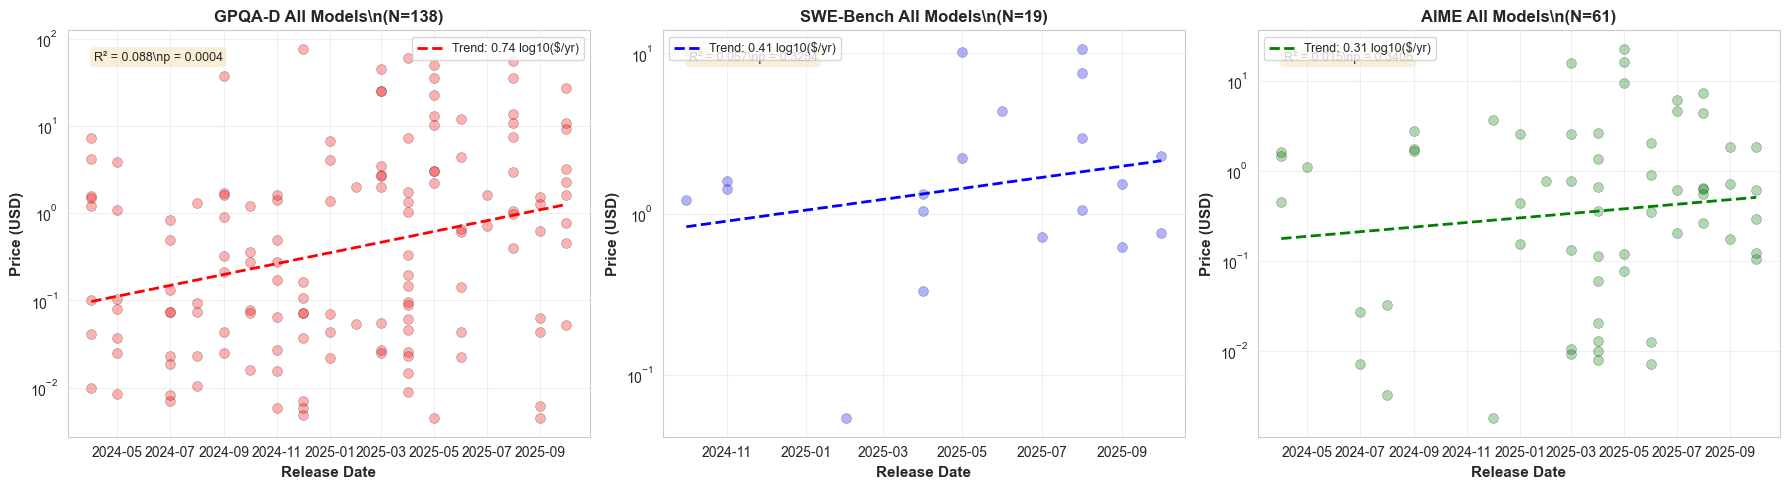

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

benchmarks_all = [
    ('GPQA-D', df_gpqa, 'red'),
    ('SWE-Bench', df_swe, 'blue'),
    ('AIME', df_aime, 'green')
]

for idx, (name, df, color) in enumerate(benchmarks_all):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df['Release Date'], df['Price'], alpha=0.3, s=50, 
              color=color, edgecolors='black', linewidth=0.5)
    
    # Fit regression line: log10(Price) ~ Years
    X = df['Years_Since_Start'].values.reshape(-1, 1)
    y = df['log_Price'].values
    model = LinearRegression().fit(X, y)
    
    # Plot trend line
    dates_range = pd.date_range(df['Release Date'].min(), df['Release Date'].max(), periods=100)
    years_range = (dates_range - df['Release Date'].min()).days / 365.25
    price_pred = 10 ** model.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, price_pred, '--', color=color, linewidth=2, 
           label=f'Trend: {model.coef_[0]:.2f} log10($/yr)')
    
    # Calculate statistics
    r_squared = model.score(X, y)
    n = len(y)
    residuals = y - model.predict(X)
    mse = np.sum(residuals**2) / (n - 2)
    X_centered = X - np.mean(X)
    se = np.sqrt(mse / np.sum(X_centered**2))
    t_stat = model.coef_[0] / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - 2))
    
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} All Models\\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add stats box
    stats_text = f'R² = {r_squared:.3f}\\np = {p_value:.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('figures/price_trends_all.png', dpi=300, bbox_inches='tight')
plt.show()

## Price Trends Over Time: All Models

This shows whether the overall model market is getting more expensive over time.

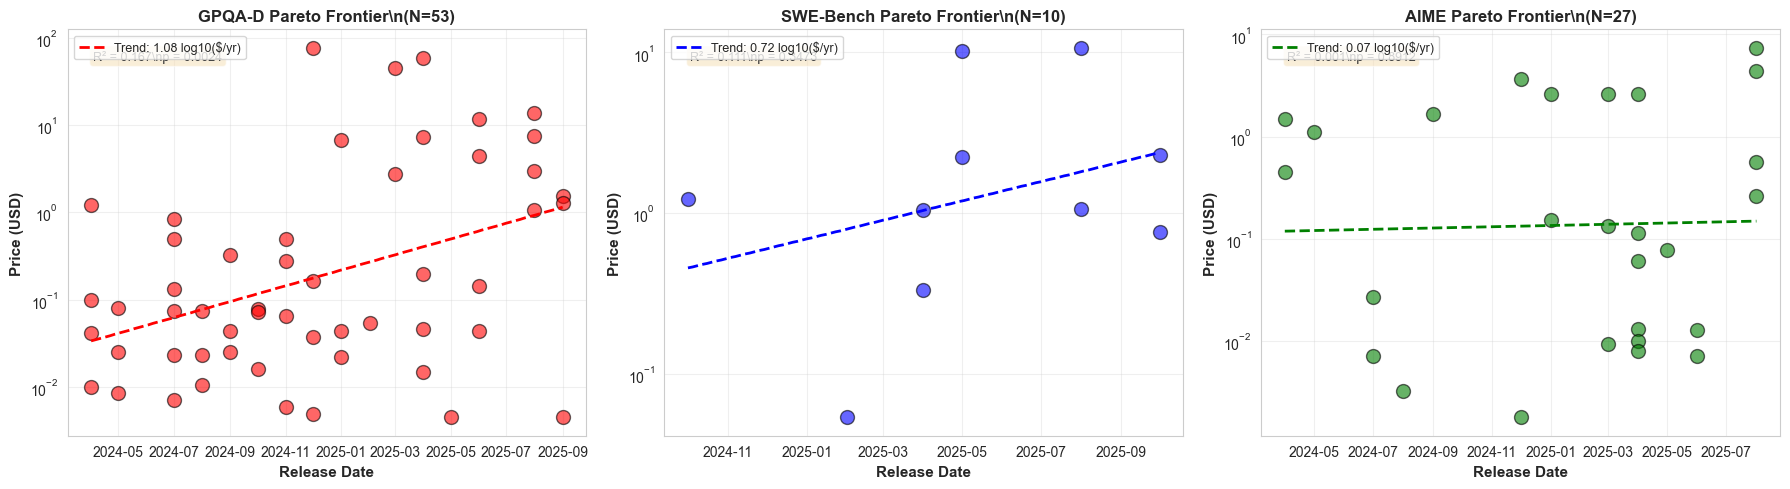

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

benchmarks = [
    ('GPQA-D', df_gpqa_pareto, 'red'),
    ('SWE-Bench', df_swe_pareto, 'blue'),
    ('AIME', df_aime_pareto, 'green')
]

for idx, (name, df, color) in enumerate(benchmarks):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df['Release Date'], df['Price'], alpha=0.6, s=100, 
              color=color, edgecolors='black', linewidth=1)
    
    # Fit regression line: log10(Price) ~ Years
    X = df['Years_Since_Start'].values.reshape(-1, 1)
    y = df['log_Price'].values
    model = LinearRegression().fit(X, y)
    
    # Plot trend line
    dates_range = pd.date_range(df['Release Date'].min(), df['Release Date'].max(), periods=100)
    years_range = (dates_range - df['Release Date'].min()).days / 365.25
    price_pred = 10 ** model.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, price_pred, '--', color=color, linewidth=2, 
           label=f'Trend: {model.coef_[0]:.2f} log10($/yr)')
    
    # Calculate statistics
    r_squared = model.score(X, y)
    n = len(y)
    residuals = y - model.predict(X)
    mse = np.sum(residuals**2) / (n - 2)
    X_centered = X - np.mean(X)
    se = np.sqrt(mse / np.sum(X_centered**2))
    t_stat = model.coef_[0] / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - 2))
    
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Pareto Frontier\\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add stats box
    stats_text = f'R² = {r_squared:.3f}\\np = {p_value:.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('figures/price_trends_pareto.png', dpi=300, bbox_inches='tight')
plt.show()

## Price Trends Over Time: Pareto Models

This shows how Pareto frontier model prices change over time for each benchmark. A steep upward trend means frontier models are getting more expensive, which creates confounding between time and price.

## Performance Trends: Observed vs Price-Adjusted

Each graph shows:
- **Blue line**: Observed performance trend (Model 1: score ~ time)
- **Red line**: Price-adjusted trend (Model 2: score ~ time + log(price), evaluated at mean price)

The difference shows how much of the progress is due to increased spending vs algorithmic improvements.

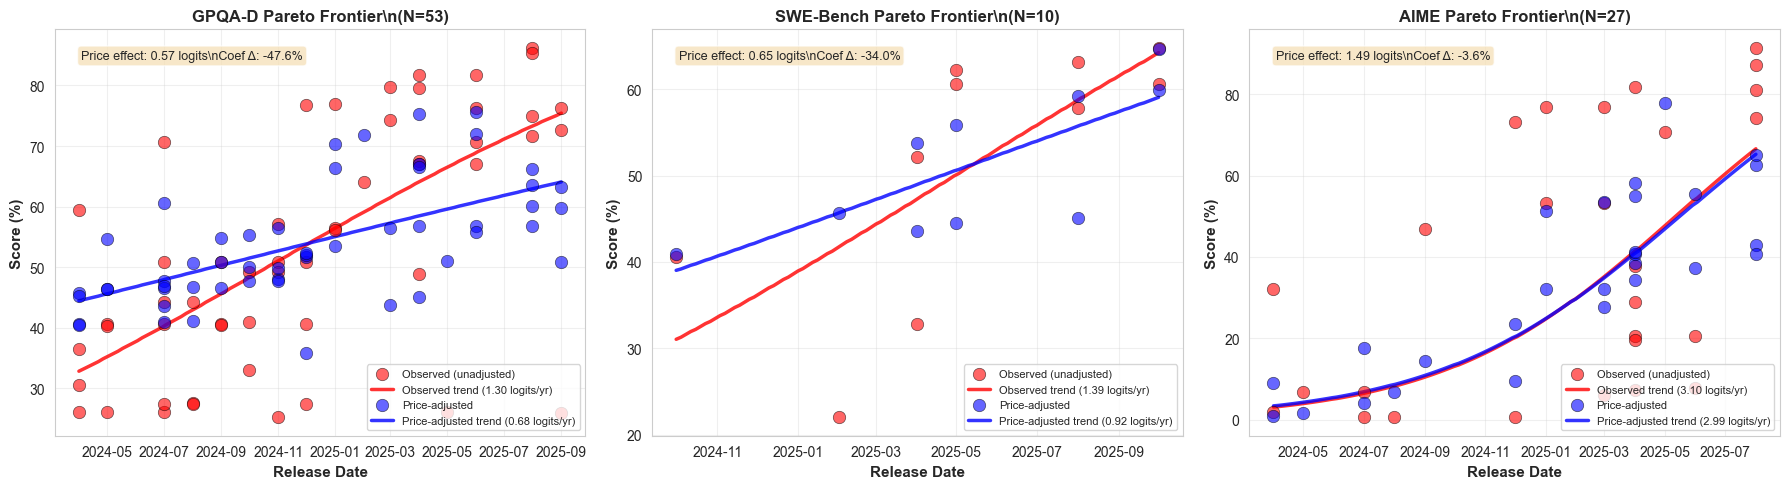

\nInterpretation:
Red points/line: What we observe (includes both algorithmic progress AND price increases)
Blue points/line: What we'd see if prices had stayed constant (pure algorithmic progress)
\nVertical distance between red and blue = effect of price increases over time


In [79]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

benchmarks = [
    ('GPQA-D', df_gpqa_pareto, 'red'),
    ('SWE-Bench', df_swe_pareto, 'blue'),
    ('AIME', df_aime_pareto, 'green')
]

for idx, (name, df, color) in enumerate(benchmarks):
    ax = axes[idx]
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_price = df['log_Price'].values.reshape(-1, 1)
    X_time_price = df[['Years_Since_Start', 'log_Price']].values
    y_logit = df['Score_logit'].values
    
    # Model 1: score ~ time (no price control)
    model1 = LinearRegression().fit(X_time, y_logit)
    pred1 = model1.predict(X_time)
    
    # Model 2: score ~ time + log(price)
    model2 = LinearRegression().fit(X_time_price, y_logit)
    
    # Calculate price-residualized points
    # Step 1: Regress score on price only to get price effect
    model_price_only = LinearRegression().fit(X_price, y_logit)
    price_effect = model_price_only.predict(X_price)
    
    # Step 2: Remove price effect from scores (residualize)
    y_residualized = y_logit - price_effect + np.mean(y_logit)  # Center at mean
    
    # Convert back to percentage scale for plotting
    y_observed_pct = inverse_logit(y_logit) * 100
    y_residualized_pct = inverse_logit(y_residualized) * 100
    
    # Plot RAW data points and trend (RED)
    ax.scatter(df['Release Date'], y_observed_pct, alpha=0.6, s=80, 
              color='red', edgecolors='black', linewidth=0.5, label='Observed (unadjusted)', zorder=3)
    
    # Red trend line (observed)
    dates_range = pd.date_range(df['Release Date'].min(), df['Release Date'].max(), periods=100)
    years_range = (dates_range - df['Release Date'].min()).days / 365.25
    pred1_logit = model1.predict(years_range.values.reshape(-1, 1))
    pred1_pct = inverse_logit(pred1_logit) * 100
    ax.plot(dates_range, pred1_pct, '-', color='red', linewidth=2.5, 
           label=f'Observed trend ({model1.coef_[0]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    # Plot PRICE-ADJUSTED points and trend (BLUE)
    ax.scatter(df['Release Date'], y_residualized_pct, alpha=0.6, s=80, 
              color='blue', edgecolors='black', linewidth=0.5, label='Price-adjusted', zorder=3)
    
    # Blue trend line (price-adjusted)
    # This is the time coefficient from model2 applied to residualized data
    model_residualized = LinearRegression().fit(X_time, y_residualized)
    pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))
    pred2_pct = inverse_logit(pred2_logit) * 100
    ax.plot(dates_range, pred2_pct, '-', color='blue', linewidth=2.5, 
           label=f'Price-adjusted trend ({model2.coef_[0]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Pareto Frontier\\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Add stats box
    coef_change = model2.coef_[0] - model1.coef_[0]
    pct_change = (coef_change / model1.coef_[0]) * 100
    price_coef = model2.coef_[1]
    
    stats_text = f'Price effect: {price_coef:.2f} logits\\n'
    stats_text += f'Coef Δ: {pct_change:+.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/binscatter_style_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\\nInterpretation:")
print("================")
print("Red points/line: What we observe (includes both algorithmic progress AND price increases)")
print("Blue points/line: What we'd see if prices had stayed constant (pure algorithmic progress)")
print("\\nVertical distance between red and blue = effect of price increases over time")

# Stylish Version 

## Binscatter-Style Plots: Raw vs Price-Adjusted Performance

These plots show:
- **Red points**: Raw observed performance
- **Red line**: Observed trend (score ~ time, no adjustment)
- **Blue points**: Price-residualized performance (price effect removed)
- **Blue line**: Price-adjusted trend (what we'd see if prices stayed constant)

This is similar to Stata's binscatter with controls, showing how much of the trend is driven by price increases.

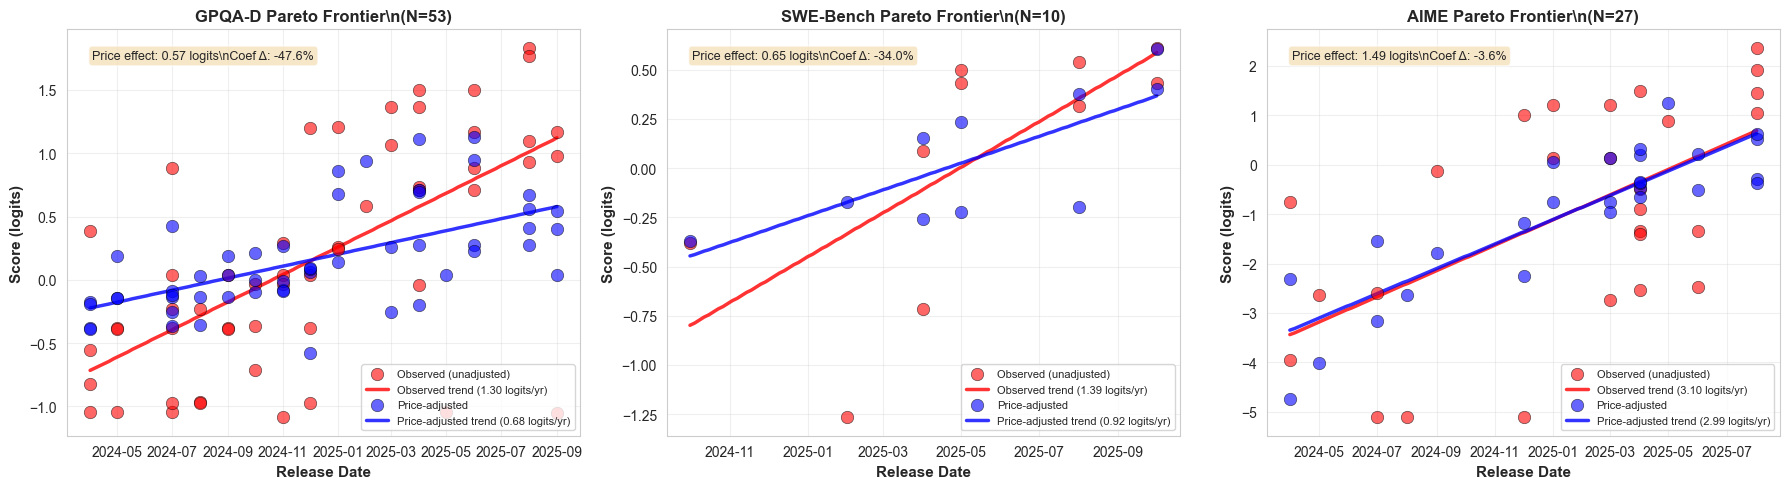


Interpretation:
Red points/line: What we observe (includes both algorithmic progress AND price increases)
Blue points/line: What we'd see if prices had stayed constant (pure algorithmic progress)

Vertical distance between red and blue = effect of price increases over time

Logit scale makes the linear relationships in the regression model more apparent.


In [80]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

benchmarks = [
    ('GPQA-D', df_gpqa_pareto, 'red'),
    ('SWE-Bench', df_swe_pareto, 'blue'),
    ('AIME', df_aime_pareto, 'green')
]

for idx, (name, df, color) in enumerate(benchmarks):
    ax = axes[idx]
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_price = df['log_Price'].values.reshape(-1, 1)
    X_time_price = df[['Years_Since_Start', 'log_Price']].values
    y_logit = df['Score_logit'].values
    
    # Model 1: score ~ time (no price control)
    model1 = LinearRegression().fit(X_time, y_logit)
    pred1 = model1.predict(X_time)
    
    # Model 2: score ~ time + log(price)
    model2 = LinearRegression().fit(X_time_price, y_logit)
    
    # Calculate price-residualized points
    # Step 1: Regress score on price only to get price effect
    model_price_only = LinearRegression().fit(X_price, y_logit)
    price_effect = model_price_only.predict(X_price)
    
    # Step 2: Remove price effect from scores (residualize)
    y_residualized = y_logit - price_effect + np.mean(y_logit)  # Center at mean
    
    # Plot RAW data points and trend (RED) - IN LOGITS
    ax.scatter(df['Release Date'], y_logit, alpha=0.6, s=80, 
              color='red', edgecolors='black', linewidth=0.5, label='Observed (unadjusted)', zorder=3)
    
    # Red trend line (observed)
    dates_range = pd.date_range(df['Release Date'].min(), df['Release Date'].max(), periods=100)
    years_range = (dates_range - df['Release Date'].min()).days / 365.25
    pred1_logit = model1.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred1_logit, '-', color='red', linewidth=2.5, 
           label=f'Observed trend ({model1.coef_[0]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    # Plot PRICE-ADJUSTED points and trend (BLUE) - IN LOGITS
    ax.scatter(df['Release Date'], y_residualized, alpha=0.6, s=80, 
              color='blue', edgecolors='black', linewidth=0.5, label='Price-adjusted', zorder=3)
    
    # Blue trend line (price-adjusted)
    # This is the time coefficient from model2 applied to residualized data
    model_residualized = LinearRegression().fit(X_time, y_residualized)
    pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred2_logit, '-', color='blue', linewidth=2.5, 
           label=f'Price-adjusted trend ({model2.coef_[0]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score (logits)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Pareto Frontier\\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Add stats box
    coef_change = model2.coef_[0] - model1.coef_[0]
    pct_change = (coef_change / model1.coef_[0]) * 100
    price_coef = model2.coef_[1]
    
    stats_text = f'Price effect: {price_coef:.2f} logits\\n'
    stats_text += f'Coef Δ: {pct_change:+.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/binscatter_style_comparison_logits.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("================")
print("Red points/line: What we observe (includes both algorithmic progress AND price increases)")
print("Blue points/line: What we'd see if prices had stayed constant (pure algorithmic progress)")
print("\nVertical distance between red and blue = effect of price increases over time")
print("\nLogit scale makes the linear relationships in the regression model more apparent.")

## GPQA-D Pareto: ICML Publication-Ready (Epoch AI Style)

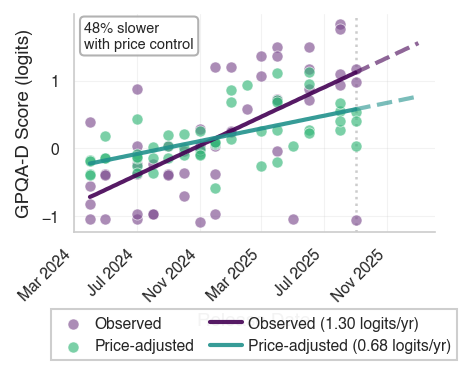


GPQA-D Pareto Frontier (N=53)
Observed trend: 1.295 logits/yr
Price-adjusted trend: 0.678 logits/yr
Coefficient change: -47.6%


In [88]:
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

# ============================================================================
# EASILY ADJUSTABLE STYLE PARAMETERS
# ============================================================================
# Font sizes
FONT_SIZE_BASE = 9
FONT_SIZE_TITLE = 10
FONT_SIZE_LABEL = 9
FONT_SIZE_TICK = 7.5
FONT_SIZE_LEGEND = 7.5
FONT_SIZE_ANNOTATION = 7

# Extrapolation
EXTRAPOLATION_MONTHS = 4

# Figure size
FIG_WIDTH = 3.25
FIG_HEIGHT = 2.8  # Increased to accommodate legend

# Colors (Viridis-inspired)
COLOR_OBSERVED = '#440154'    # Deep purple (viridis start)
COLOR_ADJUSTED = '#21918c'    # Teal (viridis middle)
COLOR_SCATTER_OBS = '#7e4e90' # Lighter purple for points
COLOR_SCATTER_ADJ = '#35b779' # Bright green for adjusted points

# ============================================================================
# Apply style settings
# ============================================================================
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': FONT_SIZE_BASE,
    'axes.titlesize': FONT_SIZE_TITLE,
    'axes.labelsize': FONT_SIZE_LABEL,
    'xtick.labelsize': FONT_SIZE_TICK,
    'ytick.labelsize': FONT_SIZE_TICK,
    'legend.fontsize': FONT_SIZE_LEGEND,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.8,
    'axes.labelpad': 4,
})

# ICML dual-column figure size
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=150)

df = df_gpqa_pareto

# Prepare data
X_time = df['Years_Since_Start'].values.reshape(-1, 1)
X_price = df['log_Price'].values.reshape(-1, 1)
X_time_price = df[['Years_Since_Start', 'log_Price']].values
y_logit = df['Score_logit'].values

# Model 1: score ~ time (no price control)
model1 = LinearRegression().fit(X_time, y_logit)

# Model 2: score ~ time + log(price)
model2 = LinearRegression().fit(X_time_price, y_logit)

# Calculate price-residualized points
model_price_only = LinearRegression().fit(X_price, y_logit)
price_effect = model_price_only.predict(X_price)
y_residualized = y_logit - price_effect + np.mean(y_logit)

# Plot data points
ax.scatter(df['Release Date'], y_logit, alpha=0.65, s=28, 
          color=COLOR_SCATTER_OBS, edgecolors='white', linewidth=0.4, 
          label='Observed', zorder=3)
ax.scatter(df['Release Date'], y_residualized, alpha=0.65, s=28, 
          color=COLOR_SCATTER_ADJ, edgecolors='white', linewidth=0.4, 
          label='Price-adjusted', zorder=3)

# Get date range with extrapolation
min_date = df['Release Date'].min()
max_date = df['Release Date'].max()
max_date_extended = max_date + pd.DateOffset(months=EXTRAPOLATION_MONTHS)

# Create prediction range (historical + extrapolation)
dates_range = pd.date_range(min_date, max_date_extended, periods=100)
years_range = (dates_range - min_date).days / 365.25

# Find the index where extrapolation starts
extrapolation_start_idx = np.argmin(np.abs(dates_range - max_date))

# Trend lines
pred1_logit = model1.predict(years_range.values.reshape(-1, 1))
model_residualized = LinearRegression().fit(X_time, y_residualized)
pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))

# Plot historical trend lines (solid)
ax.plot(dates_range[:extrapolation_start_idx+1], pred1_logit[:extrapolation_start_idx+1], 
       '-', color=COLOR_OBSERVED, linewidth=2, 
       label=f'Observed ({model1.coef_[0]:.2f} logits/yr)', alpha=0.9, zorder=4)
ax.plot(dates_range[:extrapolation_start_idx+1], pred2_logit[:extrapolation_start_idx+1], 
       '-', color=COLOR_ADJUSTED, linewidth=2, 
       label=f'Price-adjusted ({model2.coef_[0]:.2f} logits/yr)', alpha=0.9, zorder=4)

# Plot extrapolated trend lines (dashed)
ax.plot(dates_range[extrapolation_start_idx:], pred1_logit[extrapolation_start_idx:], 
       '--', color=COLOR_OBSERVED, linewidth=2, alpha=0.6, zorder=4)
ax.plot(dates_range[extrapolation_start_idx:], pred2_logit[extrapolation_start_idx:], 
       '--', color=COLOR_ADJUSTED, linewidth=2, alpha=0.6, zorder=4)

# Add vertical line to mark extrapolation boundary
ax.axvline(x=max_date, color='gray', linestyle=':', linewidth=1.2, alpha=0.4, zorder=0)

# Format x-axis with month names every 4 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=FONT_SIZE_TICK)

# Labels
ax.set_xlabel('Release Date', fontsize=FONT_SIZE_LABEL)
ax.set_ylabel('GPQA-D Score (logits)', fontsize=FONT_SIZE_LABEL)

# Light grid
ax.grid(True, alpha=0.25, linewidth=0.5, zorder=0)
ax.set_axisbelow(True)

# Legend - placed outside below the plot, horizontal layout (moved lower)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.32), 
         ncol=2, frameon=True, fancybox=False, 
         edgecolor='#cccccc', framealpha=0.95, borderpad=0.4,
         columnspacing=1.0, handletextpad=0.4, fontsize=FONT_SIZE_LEGEND)

# Add annotation for key insight
coef_change = model2.coef_[0] - model1.coef_[0]
pct_change = (coef_change / model1.coef_[0]) * 100

ax.annotate(f'{abs(pct_change):.0f}% slower\nwith price control', 
           xy=(0.03, 0.97), xycoords='axes fraction',
           fontsize=FONT_SIZE_ANNOTATION, ha='left', va='top',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='#aaaaaa', alpha=0.9))

plt.tight_layout()
plt.savefig('figures/gpqa_pareto_binned_scatter.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('figures/gpqa_pareto_icml.pdf', bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

print(f"\nGPQA-D Pareto Frontier (N={len(df)})")
print(f"Observed trend: {model1.coef_[0]:.3f} logits/yr")
print(f"Price-adjusted trend: {model2.coef_[0]:.3f} logits/yr")
print(f"Coefficient change: {pct_change:+.1f}%")

## Binscatter-Style Plots: Raw vs Price-Adjusted Performance (Logit Scale)

Same as above, but with y-axis in logits instead of percentages. This makes the linear regression relationships clearer.

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4206340133.py:68: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4206340133.py:68: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4206340133.py:69: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.savefig('figures/performance_trends_comparison.png', dpi=300, bbox_inches='tight')
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4206340133.py:69: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.savefig('figures/performance_trends_comparison.png', dpi=300, bbox_inches='tight')
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIP

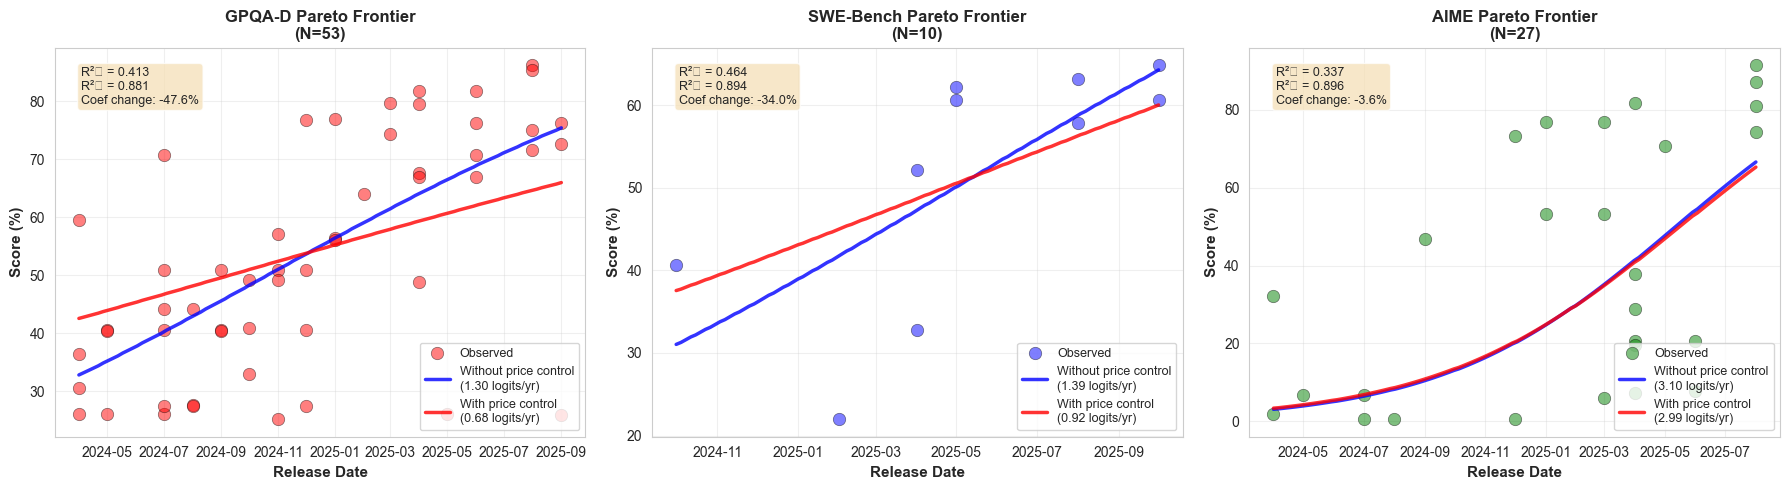

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

benchmarks = [
    ('GPQA-D', df_gpqa_pareto, 'red'),
    ('SWE-Bench', df_swe_pareto, 'blue'),
    ('AIME', df_aime_pareto, 'green')
]

for idx, (name, df, color) in enumerate(benchmarks):
    ax = axes[idx]
    
    # Scatter plot of actual data
    ax.scatter(df['Release Date'], df['Score'], alpha=0.5, s=80, 
              color=color, edgecolors='black', linewidth=0.5, label='Observed')
    
    # Prepare regression data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_time_price = df[['Years_Since_Start', 'log_Price']].values
    y_logit = df['Score_logit'].values
    
    # Model 1: Without price control (observed trend)
    model1 = LinearRegression().fit(X_time, y_logit)
    
    # Model 2: With price control
    model2 = LinearRegression().fit(X_time_price, y_logit)
    
    # Create prediction range
    dates_range = pd.date_range(df['Release Date'].min(), df['Release Date'].max(), periods=100)
    years_range = (dates_range - df['Release Date'].min()).days / 365.25
    
    # Predict with Model 1 (observed trend - no price adjustment)
    pred1_logit = model1.predict(years_range.values.reshape(-1, 1))
    pred1_score = inverse_logit(pred1_logit) * 100
    
    # Predict with Model 2 (price-adjusted - hold price at mean)
    mean_log_price = df['log_Price'].mean()
    X_pred2 = np.column_stack([years_range, np.full(len(years_range), mean_log_price)])
    pred2_logit = model2.predict(X_pred2)
    pred2_score = inverse_logit(pred2_logit) * 100
    
    # Plot trend lines
    ax.plot(dates_range, pred1_score, '-', color='blue', linewidth=2.5, 
           label=f'Without price control\n({model1.coef_[0]:.2f} logits/yr)', alpha=0.8)
    ax.plot(dates_range, pred2_score, '-', color='red', linewidth=2.5, 
           label=f'With price control\n({model2.coef_[0]:.2f} logits/yr)', alpha=0.8)
    
    # Calculate R² for both models
    r2_model1 = model1.score(X_time, y_logit)
    r2_model2 = model2.score(X_time_price, y_logit)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Pareto Frontier\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Add stats box
    coef_change = model2.coef_[0] - model1.coef_[0]
    pct_change = (coef_change / model1.coef_[0]) * 100
    
    stats_text = f'R²₁ = {r2_model1:.3f}\nR²₂ = {r2_model2:.3f}\n'
    stats_text += f'Coef change: {pct_change:+.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/performance_trends_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Performance Trends: Observed vs Price-Adjusted (Logit Scale)

Same analysis as above, but with y-axis in logits instead of percentages.

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4213774849.py:88: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4213774849.py:88: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4213774849.py:89: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.savefig('figures/performance_trends_comparison_logits.png', dpi=300, bbox_inches='tight')
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98461/4213774849.py:89: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.savefig('figures/performance_trends_comparison_logits.png', dpi=300, bbox_inches='tight')
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 832

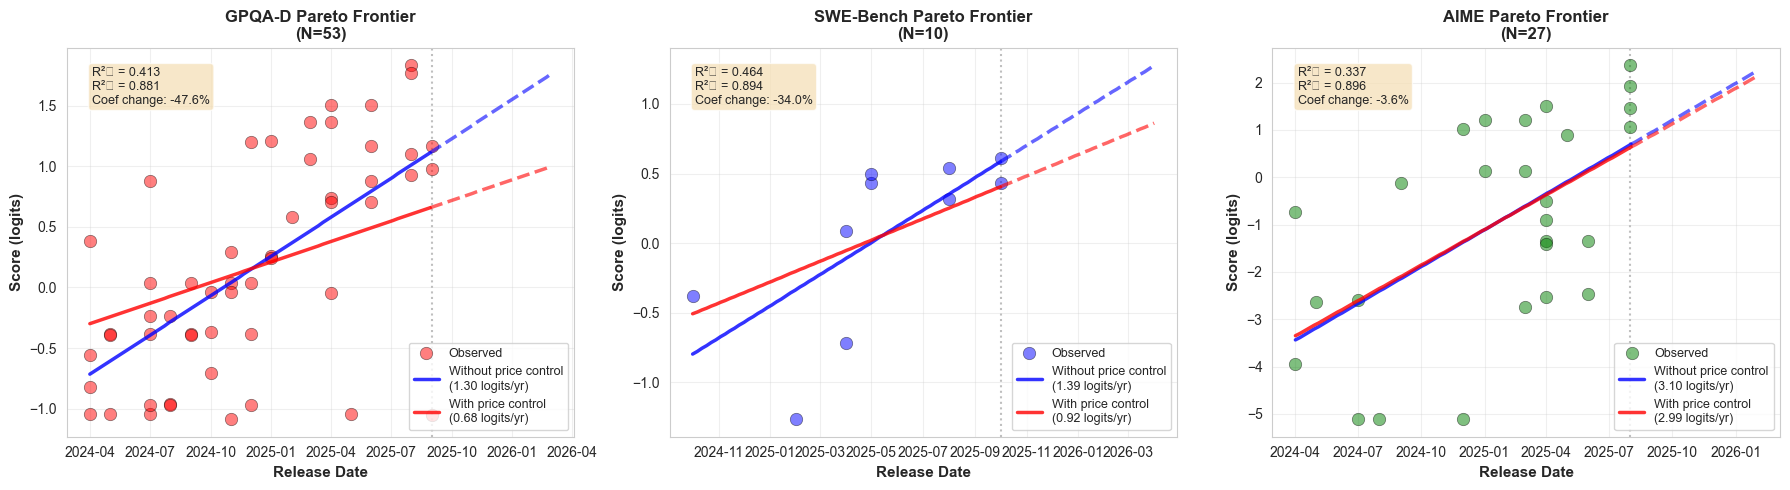

In [82]:
# Extrapolation period in months (easily modifiable)
extrapolation_months = 6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

benchmarks = [
    ('GPQA-D', df_gpqa_pareto, 'red'),
    ('SWE-Bench', df_swe_pareto, 'blue'),
    ('AIME', df_aime_pareto, 'green')
]

for idx, (name, df, color) in enumerate(benchmarks):
    ax = axes[idx]
    
    # Scatter plot of actual data (in logits)
    ax.scatter(df['Release Date'], df['Score_logit'], alpha=0.5, s=80, 
              color=color, edgecolors='black', linewidth=0.5, label='Observed')
    
    # Prepare regression data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_time_price = df[['Years_Since_Start', 'log_Price']].values
    y_logit = df['Score_logit'].values
    
    # Model 1: Without price control (observed trend)
    model1 = LinearRegression().fit(X_time, y_logit)
    
    # Model 2: With price control
    model2 = LinearRegression().fit(X_time_price, y_logit)
    
    # Get date range
    min_date = df['Release Date'].min()
    max_date = df['Release Date'].max()
    max_date_extended = max_date + pd.DateOffset(months=extrapolation_months)
    
    # Create prediction range (historical + extrapolation)
    dates_range = pd.date_range(min_date, max_date_extended, periods=100)
    years_range = (dates_range - min_date).days / 365.25
    
    # Find the index where extrapolation starts
    extrapolation_start_idx = np.argmin(np.abs(dates_range - max_date))
    
    # Predict with Model 1 (observed trend - no price adjustment)
    pred1_logit = model1.predict(years_range.values.reshape(-1, 1))
    
    # Predict with Model 2 (price-adjusted - hold price at mean)
    mean_log_price = df['log_Price'].mean()
    X_pred2 = np.column_stack([years_range, np.full(len(years_range), mean_log_price)])
    pred2_logit = model2.predict(X_pred2)
    
    # Plot historical trend lines (in logits)
    ax.plot(dates_range[:extrapolation_start_idx+1], pred1_logit[:extrapolation_start_idx+1], 
           '-', color='blue', linewidth=2.5, 
           label=f'Without price control\n({model1.coef_[0]:.2f} logits/yr)', alpha=0.8)
    ax.plot(dates_range[:extrapolation_start_idx+1], pred2_logit[:extrapolation_start_idx+1], 
           '-', color='red', linewidth=2.5, 
           label=f'With price control\n({model2.coef_[0]:.2f} logits/yr)', alpha=0.8)
    
    # Plot extrapolated trend lines (dashed)
    ax.plot(dates_range[extrapolation_start_idx:], pred1_logit[extrapolation_start_idx:], 
           '--', color='blue', linewidth=2.5, alpha=0.6)
    ax.plot(dates_range[extrapolation_start_idx:], pred2_logit[extrapolation_start_idx:], 
           '--', color='red', linewidth=2.5, alpha=0.6)
    
    # Add vertical line to mark extrapolation boundary
    ax.axvline(x=max_date, color='gray', linestyle=':', linewidth=1.5, alpha=0.5, zorder=0)
    
    # Calculate R² for both models
    r2_model1 = model1.score(X_time, y_logit)
    r2_model2 = model2.score(X_time_price, y_logit)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score (logits)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} Pareto Frontier\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Add stats box
    coef_change = model2.coef_[0] - model1.coef_[0]
    pct_change = (coef_change / model1.coef_[0]) * 100
    
    stats_text = f'R²₁ = {r2_model1:.3f}\nR²₂ = {r2_model2:.3f}\n'
    stats_text += f'Coef change: {pct_change:+.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/performance_trends_comparison_logits.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics Table

In [83]:
def calculate_trend_stats(df, benchmark_name):
    """Calculate statistics for both models"""
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_time_price = df[['Years_Since_Start', 'log_Price']].values
    y_logit = df['Score_logit'].values
    
    # Model 1: Without price control
    model1 = LinearRegression().fit(X_time, y_logit)
    r2_1 = model1.score(X_time, y_logit)
    
    # Model 2: With price control
    model2 = LinearRegression().fit(X_time_price, y_logit)
    r2_2 = model2.score(X_time_price, y_logit)
    
    # Calculate p-values
    n = len(y_logit)
    
    # Model 1 p-value
    residuals1 = y_logit - model1.predict(X_time)
    mse1 = np.sum(residuals1**2) / (n - 2)
    X_centered = X_time - np.mean(X_time)
    se1 = np.sqrt(mse1 / np.sum(X_centered**2))
    t_stat1 = model1.coef_[0] / se1
    p_value1 = 2 * (1 - stats.t.cdf(np.abs(t_stat1), n - 2))
    
    # Model 2 p-values
    residuals2 = y_logit - model2.predict(X_time_price)
    mse2 = np.sum(residuals2**2) / (n - 3)
    XtX_inv = np.linalg.inv(X_time_price.T @ X_time_price)
    se_coefs2 = np.sqrt(np.diag(XtX_inv) * mse2)
    t_stat2_time = model2.coef_[0] / se_coefs2[0]
    t_stat2_price = model2.coef_[1] / se_coefs2[1]
    p_value2_time = 2 * (1 - stats.t.cdf(np.abs(t_stat2_time), n - 3))
    p_value2_price = 2 * (1 - stats.t.cdf(np.abs(t_stat2_price), n - 3))
    
    coef_change = model2.coef_[0] - model1.coef_[0]
    pct_change = (coef_change / model1.coef_[0]) * 100
    
    return {
        'Benchmark': benchmark_name,
        'N': n,
        'Time Coef (no price)': model1.coef_[0],
        'p-value': p_value1,
        'R² (no price)': r2_1,
        'Time Coef (w/ price)': model2.coef_[0],
        'p-value.1': p_value2_time,
        'Price Coef': model2.coef_[1],
        'Price p-value': p_value2_price,
        'R² (w/ price)': r2_2,
        'Coef Δ': coef_change,
        'Coef Δ (%)': pct_change
    }

results = []
results.append(calculate_trend_stats(df_gpqa_pareto, 'GPQA-D'))
results.append(calculate_trend_stats(df_swe_pareto, 'SWE-Bench'))
results.append(calculate_trend_stats(df_aime_pareto, 'AIME'))

summary_df = pd.DataFrame(results)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)

print("\n" + "="*140)
print("PERFORMANCE TREND COMPARISON: PARETO FRONTIER")
print("="*140 + "\n")
print(summary_df.to_string(index=False))

summary_df.to_csv('results/performance_trend_comparison.csv', index=False)
print("\n\nSaved to: results/performance_trend_comparison.csv")


PERFORMANCE TREND COMPARISON: PARETO FRONTIER

Benchmark  N  Time Coef (no price)    p-value  R² (no price)  Time Coef (w/ price)  p-value.1  Price Coef  Price p-value  R² (w/ price)  Coef Δ  Coef Δ (%)
   GPQA-D 53                1.2955 2.0830e-07         0.4134                0.6783 2.2204e-16      0.5710     0.0000e+00         0.8806 -0.6172    -47.6390
SWE-Bench 10                1.3861 3.0036e-02         0.4643                0.9153 8.4363e-05      0.6544     9.2038e-04         0.8940 -0.4708    -33.9638
     AIME 27                3.0956 1.4892e-03         0.3374                2.9855 4.1300e-14      1.4930     9.3627e-12         0.8960 -0.1101     -3.5560


Saved to: results/performance_trend_comparison.csv


## Interpretation

**Gap Between Lines = Effect of Price Increases**

1. **GPQA-D**: Large gap between blue and red lines
   - Time coefficient drops ~47% when controlling for price
   - Much of the "progress" is just spending more money
   
2. **SWE-Bench**: Moderate gap
   - Time coefficient drops ~34% when controlling for price
   - Some progress from spending, but also real algorithmic gains
   
3. **AIME**: Tiny gap (lines nearly overlap)
   - Time coefficient drops only ~3.6% when controlling for price
   - Almost all progress is algorithmic, not from spending more

**Key Finding**: Math reasoning (AIME) shows genuine algorithmic progress independent of scale/spending, while scientific reasoning (GPQA-D) and coding (SWE-Bench) show more confounding between progress and increased compute budgets.